In [120]:
from decimal import Decimal

In [121]:
class Token:       
    def __init__(self, _name = ""):
        self.balances = {}
        self.totalSupply = 0
        self._name = _name
    
    def mint(self, address, amount):
        assert(amount > 0)
        self.balances[address] = self.balances.get(address, 0) + amount
        self.totalSupply += amount
        return True
        
    def burn(self, address, amount):
        assert(amount > 0)
        if self.balances[address] < amount:
            raise Exception("burn: Cannot burn more value than present at address")
        self.balances[address] = self.balances.get(address, 0) - amount
        self.totalSupply -= amount
        return True
    
    def balanceOf(self, address):
        return self.balances.get(address, 0)
    
    def name(self):
        return self._name
    
    def transferFrom(self, sender, recipient, amount):
        assert(amount >= 0)
        # always round
        if self.balanceOf(sender) >= amount:
            self.balances[sender] = self.balances.get(sender, 0) - amount
            self.balances[recipient] = self.balances.get(recipient, 0) + amount    
            return True
        else:
            raise Exception("transferFrom: Cannot transfer more than balance")

In [122]:
# Basic test of Token class

token = Token()
token.mint("A", 5)
assert(token.balanceOf("A") == 5)

token.transferFrom("A", "B", 3)
assert(token.balanceOf("B") == 3)
assert(token.balanceOf("A") == 2)

token.transferFrom("A", "C", 2)
assert(token.balanceOf("A") == 0)
assert(token.balanceOf("C") == 2)

In [123]:
def assertNearly(first_value, second_value, msg, decimals=15):
    assert(round(first_value, decimals) == round(second_value, decimals)) 
    

In [124]:
assertNearly(1,1,"ok")
#assertNearly(Decimal('1'),Decimal('2'),"ok")
assertNearly(Decimal('1.01'),Decimal('1.02'),"ok", 1)
#assertNearly(Decimal('1.01'),Decimal('1.02'),"ok", 2)

In [125]:
import time 
import decimal
from decimal import Decimal 
math = decimal.Context()

# class InterestToken
#  __init__(rate, _rateAccumulator)
#  balanceOfUnderlying(address)
#  accrueInterest()
#  updateRate(update)
#  yearlyRate()

class blockchain:
    
    def __init__(self, _timestamp, _block):
        self.timestamp = _timestamp
        self.block = _block
    
    def incrementBlock(self):
        self.block += 1
        self.timestamp += 15
    
    def updateTimestamp(self, _timestamp):
        self.timestamp = _timestamp
    
    def now(self):
        return self.timestamp


class InterestToken(Token):
    # rate is a yearly rate, converted to a rate compounded per second
    def __init__(self, _name, _blockchain, rate, _rateAccumulator):
        Token.__init__(self, _name)
        self.blockchain = _blockchain
        self.lastUpdate = self.blockchain.now()
        self.rateAccumulator = _rateAccumulator
        # 31622400 is the number of seconds in a year
        self.rate = math.power(1 + Decimal(rate), 1/Decimal(31622400))  
        self.interestRateLimit = math.power(1 + Decimal(2), 1/Decimal(31622400)) 
    
    def balanceOfUnderlying(self, address):
        return self.balanceOf(address) * self.rateAccumulator
    
    def transferUnderlying(self, sender, recipient, amount):
        value = amount / self.rateAccumulator
        return self.transferFrom(sender, recipient, value)
        
    def accrueInterest(self):
        now = self.blockchain.now()
        if now > self.lastUpdate:
            total_time =  now - self.lastUpdate
            self.rateAccumulator = math.power(self.rate, total_time) * self.rateAccumulator
            self.lastUpdate = now
    
    def updateRate(self, update):
        newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) - 1
        self.rate = self.rate + newRate
        if self.rate < Decimal(1):
            self.rate = Decimal(1)
        if self.rate > self.interestRateLimit:
            self.rate = self.interestRateLimit
    
    def yearlyRate(self):
        return math.power(self.rate, Decimal(31622400)) - 1
    
    def mintInUnderlying(self, address, amount):
        self.mint(address, amount/self.rateAccumulator)
        
    def burnInUnderlying(self, address, amount):
        self.burn(address, amount/self.rateAccumulator)

In [126]:
# Basic tests of Interest Token Class

chain = blockchain(0,1)
token = InterestToken("Token", chain, .02, 1)
token.mint("A", 1000)
#token.lastUpdate = token.lastUpdate - 31622400
chain.updateTimestamp(31622400)
token.accrueInterest()
token.balanceOfUnderlying("A")
assert(int(token.balanceOfUnderlying("A")) == 1020)

In [127]:
chain = blockchain(0,1)
token = InterestToken("Token", chain, .02, 1)
token.mint("A", 1000)
#token.lastUpdate = token.lastUpdate - 31622400
# Note that the per second rates are multiplied, not added
token.updateRate(.001)
token.updateRate(.001)
token.updateRate(-.001)
token.updateRate(.001)
token.updateRate(.001)
#print(token.yearlyRate())
chain.updateTimestamp(31622400)
#print(token.rate)
token.accrueInterest()
assert(int(token.balanceOfUnderlying("A")) == 1023)

In [128]:
chain = blockchain(1,1)
uToken = InterestToken("Token", chain, .04, 1)
for x in range(10000):
    chain.incrementBlock()
    uToken.accrueInterest()

#uToken.rateAccumulator

In [256]:
class QueueExchange(Token):
    def __init__(self, _token, _uToken : Token , _sToken : InterestToken):
        super().__init__(_token)
        self.uToken = _uToken
        self.sToken = _sToken
        self.underlying = 0
        self.synthetic  = 0
        self.address = '0x' + _token
        self.book = {}
        self.uTokenBalance = 0
        self.sTokenBalance = 0
        self.sTokenBalanceUnderlying = 0
        self.conversionRate = Decimal('1')
        self.savedRateAccumulator = self.sToken.rateAccumulator
        self.fee = Decimal('0.0005')
        
        
    # This proxy function lets us add logic to transfers if needed later
    def transferToken(self, token, sender, recipient, amount):
        assert(self.uTokenBalance >= 0)
        assert(self.sTokenBalance >= 0)
        if token == self.sToken:
            return token.transferUnderlying(sender, recipient, amount)
        else:
            return token.transferFrom(sender, recipient, amount)
    
    def balanceOfUnderlying(self, address):
        return self.balanceOf(address) * self.conversionRate
    
    # Before changing the self.totalSupply of the Liquidity Provisioning shares, 
    # we must make sure we update the self.conversionRate 
    # self.totalSupply is not changed by adding accumulated interest
    def collectSyntheticInterest(self):
        if self.totalSupply == 0:
            return True
        # calculate interest earned
        interestEarned = self.sTokenBalance * (self.sToken.rateAccumulator - self.savedRateAccumulator)
        if interestEarned < Decimal('0.000000000000000001'):
            # don't update if interest is negligible
            return
        assert(interestEarned >= 0)
        # interest is shared across all users
        newTotalValue = (self.totalSupply * self.conversionRate)  + interestEarned
        oldConversionRate = self.conversionRate
        self.conversionRate = newTotalValue / self.totalSupply 
        # update 
        self.savedRateAccumulator = self.sToken.rateAccumulator
        self.sTokenBalanceUnderlying = self.sTokenBalanceUnderlying + interestEarned
        
        # check that coversionRate is strictly increasing
        if self.conversionRate < oldConversionRate:
            raise Exception("collectSyntheticInterest: conversionRate decreased, somehow old: {} new: {}".format(oldConversionRate, self.conversionRate))
        
        # check sToken balance invariant
        try:
            assert(round(self.sTokenBalanceUnderlying,10) == round(self.sTokenBalance*self.sToken.rateAccumulator, 10))
        except:
            raise Exception("collectSyntheticInterest: sToken balance mismatch sTokenBalanceUnderlying:{} sTokenBalance:{} conversionRate:{}".format(self.sTokenBalanceUnderlying, self.sTokenBalance, self.conversionRate))
        
        # fail if our accounting of balance does not match true balance
        # this cannot be done in Solidity as transfers can be sent without contracts consent
        try:
            assert(round(self.sTokenBalanceUnderlying,10) == round(self.sToken.balanceOfUnderlying(self.address), 10))
        except:
            print("sTokenBalanceUnderlying {} does not equal balanceOfUnderlying {} ".format(self.sTokenBalanceUnderlying,self.sToken.balanceOfUnderlying(self.address))
                 ) 
            print("balanceOf: {} rateAccumulator: {}".format(self.sToken.balanceOf(self.address), self.sToken.rateAccumulator))
            print("interestEarned: {} newTotalValue: {}".format(interestEarned, newTotalValue))
            pass
        return
        
    def depositUnderlying(self, address, amount):
        if amount > 0:
            # before updating, collect interest
            self.collectSyntheticInterest()
            result = self.transferToken(self.uToken, address, self.address, amount)
            if not result:
                raise Exception('depositUnderlying: Transfer Failed')
            self.uTokenBalance += amount
            self.balances[address] = self.balances.get(address, 0) + amount/self.conversionRate
            self.totalSupply += amount/self.conversionRate
            return True
        else:
            raise Exception("depositUnderlying: Cannot deposit zero or negative funds")
        
    # Deposit synthetic. Amount is denominated in underlying
    def depositSynthetic(self, address, amount):
        if amount > 0:        
            # before updating, collect interest
            self.collectSyntheticInterest()
            #Transfer synthetic
            result = self.transferToken(self.sToken, address, self.address, amount)
            if not result:
                raise Exception('depositUnderlying: Transfer Failed')
            self.sTokenBalance += amount / self.sToken.rateAccumulator
            self.sTokenBalanceUnderlying += amount
            self.balances[address] = self.balances.get(address, 0) + amount/self.conversionRate
            self.totalSupply += amount/self.conversionRate
            return True
        else:
            raise Exception("depositUnderlying: Cannot deposit zero or negative funds")
    
    # withdraw underlying token using underlying token as unit of account 
    def withdrawUnderlying(self, address, amount):
        if amount > 0:
            # before updating, collect interest
            self.collectSyntheticInterest()
            #check if funds are sufficient
            if amount > self.balanceOfUnderlying(address):
                raise Exception("withdrawUnderlying: Cannot withdraw more than balance Requested {}, Available {}".format(amount, self.balances.get(address, 0) * self.conversionRate))
            # Is there enough balance to send?
            if amount > self.uTokenBalance:
                raise Exception("withdrawUnderlying: Insufficient balance in exchange")
            self.balances[address] -= amount/self.conversionRate
            # when withdrawing underlying, a fee is taken
            fee = amount * self.fee
            amountMinusFee = amount - fee
            newTotalValue = (self.totalSupply * self.conversionRate)  - amountMinusFee
            self.totalSupply -= amount/self.conversionRate
            self.uTokenBalance -= amountMinusFee
            self.conversionRate = newTotalValue / self.totalSupply 
            return self.transferToken(self.uToken, self.address, address, amountMinusFee)
        else:
            raise Exception("withdrawUnderlying: Cannot withdraw zero or negative tokens")
    
    def maxUnderlying(self):
        return min(self.uToken.balanceOf(self.address), self.uTokenBalance)
    
    def maxSynthetic(self):
        return min(self.sToken.balanceOfUnderlying(self.address), self.sTokenBalanceUnderlying)
        
    
    # withdraw synthetic token using underlying token as unit of account
    def withdrawSynthetic(self, address, amount):
        if amount > 0:
            # before updating, collect interest
            self.collectSyntheticInterest()
            #check if funds are sufficient
            if amount > self.balances.get(address, 0) * self.conversionRate:
                raise Exception("withdrawSynthetic: Cannot withdraw more than balance Requested {}, Available {}".format(amount, self.balances.get(address, 0) * self.conversionRate))
            # Is there enough balance to send?
            if amount > self.sTokenBalanceUnderlying:
                raise Exception("withdrawSynthetic: Insufficient balance in exchange. Requested {}, Available {}".format(amount, self.sTokenBalanceUnderlying))
            # Double check by checking balance of synthetic
            if amount > self.sToken.balanceOfUnderlying(self.address):
                raise Exception("withdrawSynthetic: Insufficient balance in exchange. Requested {}, Available {}".format(amount, self.sToken.balanceOfUnderlying(self.address)))
            self.balances[address] -= amount/self.conversionRate
            self.totalSupply -= amount/self.conversionRate
            self.sTokenBalance -= amount / self.sToken.rateAccumulator
            self.sTokenBalanceUnderlying -= amount
            return self.transferToken(self.sToken, self.address, address, amount)
        else:
            raise Exception("withdrawSynthetic: Cannot withdraw zero or negative tokens")
    
    def measureImbalance(self):
        self.collectSyntheticInterest()
        # If balance difference is under 5% of the total, treat as if there is no imbalance 
        if self.totalSupply == 0:
            return Decimal('0')
        if abs(Decimal(self.uTokenBalance - self.sTokenBalanceUnderlying) / Decimal(self.totalSupply * self.conversionRate)) < Decimal('0.5'):
            return Decimal('0')
        return self.uTokenBalance - self.sTokenBalanceUnderlying
    
        

In [257]:
# Some basic testing of QX
chain = blockchain(1,1)
uToken = Token("Token")
uToken.mint("A", Decimal('1000'))
sToken = InterestToken("pyToken", chain, Decimal('.04'), Decimal('1'))
sToken.mint("B", Decimal('1000'))
qx = QueueExchange("QX", uToken, sToken)
qx.depositUnderlying("A", Decimal('1000'))
qx.depositSynthetic("B", Decimal('1000'))
#Add in some interest
chain.updateTimestamp(31622400)
uToken.mint("C", Decimal('1000'))
sToken.accrueInterest()
qx.depositUnderlying("C", Decimal('1000'))
qx.withdrawSynthetic("C", qx.balanceOfUnderlying("C"))

True

In [258]:
chain = blockchain(1,1)
uToken = Token("Token")
uToken.mint("A", Decimal('1000'))
sToken = InterestToken("pyToken", chain, Decimal('.04'), Decimal('1'))
sToken.mint("B", Decimal('1000'))
qx = QueueExchange("QX", uToken, sToken)
qx.depositUnderlying("A", Decimal('1000'))
qx.depositSynthetic("B", Decimal('1000'))
chain.updateTimestamp(31622400)
sToken.accrueInterest()
qx.collectSyntheticInterest()
# Half underlying, Half pyToken means half the total interest rate
assert(qx.conversionRate == Decimal('1.019999999355053037491798033'))
qx.withdrawUnderlying("B", 500)
assert(qx.conversionRate == Decimal('1.020165583770671446317224349'))
qx.withdrawSynthetic("A", 500)
chain.updateTimestamp(2 * 31622400)
sToken.accrueInterest()
qx.collectSyntheticInterest()
assert(uToken.balanceOf("0xQX") + sToken.balanceOfUnderlying("0xQX") - \
       (qx.conversionRate * qx.totalSupply) < Decimal('0.000000000000000001'))

In [259]:
class Oracle:
    def __init__(self, _tokenA, _tokenB):
        self.tokenA = _tokenA
        self.tokenB = _tokenB
        # Price is stored in terms of TokenB
        self.price = 0 
    
    # Assumes price is in terms of Token B
    def currentPrice(self):
        return self.price
    
    # Assumes price is in terms of Token B
    def setPrice(self, price):
        self.price = price
        
    def setPriceInToken(self, token, price):
        if token == self.tokenA:
            self.price = 1 / price
        else:
            self.price = price
            
    def getPriceInToken(self, token):
        if token == self.tokenA:
            return Decimal('1') /self.price
        else:     
            return self.price

In [260]:
# Simple Test of Oracle
ETH = Token("ETH")
DAI = Token("DAI")
oracle = Oracle(ETH, DAI)
oracle.setPriceInToken(DAI, Decimal('100'))
assert(oracle.getPriceInToken(DAI) == Decimal('100'))
assert(oracle.getPriceInToken(ETH) == (Decimal('1')/Decimal('100')))


In [261]:
class pyToken (InterestToken):
    def __init__(self, _blockchain, _underlying : Token, _oracle):  
        super().__init__("", _blockchain, Decimal('0'), Decimal('1'))
        self.underlying = _underlying
        self._name = "py" + self.underlying.name()
        self.cdp = {self.underlying.name(): {}}
        self.tokens = {}
        self.address = '0x' + self.name()
        # oracle for the pyToken <> pyToken pair
        self.oracle = _oracle
        self.qx = 0
        self.interestUpdateAmount = Decimal('0.0001')
        self.collateralizationRatio = Decimal('1.7')
        self.debtAccumulator = self.rateAccumulator
        self.debtRate = self.rate
        # bonus factor when liquidating
        self.bonus = Decimal('1.1')
        
    # Admin Functions
    def setPair(self, _pairedpyToken : InterestToken):
        self.pairedpyToken = _pairedpyToken  
        self.tokens[self.pairedpyToken.name()] = self.pairedpyToken
        self.cdp[self.pairedpyToken.name()] = {}
        
    def setQueueExchange(self,exchange):
        self.qx = exchange
        
    def addCollateralType(self, token, oracle):
        self.tokens[token.name()] = { 'token':token, 'oracle':oracle }
        self.cdp[token.name()] = {}
    
    # User Functions
    def addCollateral(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        result = self.tokens[token]['token'].transferFrom(address, self.address, amount)
        if result:
            if address not in self.cdp[token]:
                self.cdp[token][address] = {'amount':amount, 'debt':Decimal('0')}
            else:
                self.cdp[token][address]['amount'] += amount
        else:
            return False
      
    def withdrawCollateral(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        # check oracle price
        price = self.oracle.currentPrice()
        minimumCollateral = self.oracle.currentPrice() * self.collateralizationRatio * \
                            (self.cdp[token][address]['debt'] * self.debtAccumulator - amount)
        if self.cdp[token][address]['amount'] < minimumCollateral:
            raise Exception("withdrawCollateral: Insufficient free capital to withdraw")
        result = self.tokens[token].transferFrom(self.address, address, amount)
        if result:
            self.cdp[token][address]['amount'] = self.cdp[token][address]['amount'] - amount
    
    # accrue for both debt and interest
    def accrueInterest(self):
        now = self.blockchain.now()
        if now > self.lastUpdate:
            total_time =  now - self.lastUpdate
            self.rateAccumulator = math.power(self.rate, total_time) * self.rateAccumulator
            self.debtAccumulator = math.power(self.debtRate, total_time) * self.debtAccumulator
            self.lastUpdate = now
        
    # updateRate for both debt and interest
    # this contract implicity assumes that this is called every block
    def updateRate(self, update):
        newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) - 1
        self.rate = self.rate + newRate
        self.debtRate = self.rate + newRate
        if self.rate < Decimal(1):
            self.rate = Decimal(1)
        if self.rate > self.interestRateLimit:
            self.rate = self.interestRateLimit
        
    
    def getCollateral(self, token, address):
        return self.cdp[token][address]['amount'] 
    
    def getDebt(self, token, address):
        return self.cdp[token][address]['debt'] 
    
    def debtInUnderlying(self, token, address):
        return self.cdp[token][address]['debt'] * self.debtAccumulator
    
    # borrow against a particular tokens worth of collateral
    def borrow(self, token, address, amount):
        if token not in self.tokens.keys():
            raise Exception("Borrow: Token not found")
        if amount < 0:
            raise Exception("Borrow: Cannot borrow negative amounts")
            self.tokens[token.name()] = { 'token':token, 'oracle':oracle }
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        minimumCollateral = ( 1 / price) * self.collateralizationRatio * \
                            (self.cdp[token][address]['debt'] * self.debtAccumulator + amount)
        if self.cdp[token][address]['amount'] < minimumCollateral:
            raise Exception("Borrow: Insufficient collateral Available: {} Minimum Needed: {}".format(self.cdp[token][address]['amount'], minimumCollateral))
        # Add debt
        self.cdp[token][address]['debt'] = self.cdp[token][address]['debt'] + Decimal(amount) / self.debtAccumulator
        # Add borrow
        self.mintInUnderlying(address, amount)
        try:
            assert(self.balanceOfUnderlying(address) >= amount)
        except:     
            print("amount minted: {} balance: {}".format(amount, self.balanceOfUnderlying(address)))
        
    def maximumBorrow(self, token, address):
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        maximumBorrow = self.cdp[token][address]['amount'] * price * \
                         (1 / self.collateralizationRatio) 
        return maximumBorrow
    

       
    def liquidate(self, token, addressToLiquidate, LiquidatorAddress, amount):
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        maximumBorrow = self.maximumBorrow(token, addressToLiquidate)
        debt = self.debtInUnderlying(token, addressToLiquidate)
        if maximumBorrow < debt:
            # We need to liquidate
            if amount < debt:
                raise Exception("liquidate: Must liquidate entire CDP at once")
            availableFunds = self.balanceOfUnderlying(LiquidatorAddress)
            if availableFunds < amount:
                raise Exception("liquidate: Insufficient funds to liquidate")
            
            collateralToLiquidator = debt*self.bonus/price
            if collateralToLiquidator > self.cdp[token][addressToLiquidate]['amount']:
                raise Exception("liquidate: CDP liquidated while undercollateralized. Owed to Liquidator: {} Available: {}".format(collateralToLiquidator, self.cdp[token][addressToLiquidate]['amount']))
            # Only burn amount of debt--it's possible to specify more than debt and have liquidate succeed
            self.burn(LiquidatorAddress, self.getDebt(token, addressToLiquidate))
            # Transfer liquidated funds to Liquidator
            self.tokens[token]['token'].transferFrom(self.address, LiquidatorAddress, collateralToLiquidator)
            # Debit CDP account 
            self.cdp[token][addressToLiquidate]['amount'] -= collateralToLiquidator
            # Wipe Debt
            self.cdp[token][addressToLiquidate]['debt'] = 0
        else:
            raise Exception("liquidate: Cannot liquidate a working CDP")
        
    # Position in a particular collateral token
    def position(self, token, address):
        return self.cdp[token][address]
    
    def repay(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        if amount < 0:
            return False        
        if amount < self.debtInUnderlying(token, address):
            raise Exception("Cannot repay more than available debt")
        # Decrease debt
        self.cdp[token][address]['debt'] = self.cdp[token][address]['debt'] - Decimal(amount) / self.debtAccumulator
        assert(self.cdp[token][address]['debt'] >= 0)
        self.burnInUnderlying(address, amount)
        
        
    def updateRates(self):
        imbalance = self.qx.measureImbalance()
        if imbalance == 0:
            return 
        if imbalance > 0:
            # lower interest rate
            self.updateRate(-self.interestUpdateAmount)
        elif imbalance < 0:
            # raise interest rate
            self.updateRate(self.interestUpdateAmount)
    
        
        
    
    

In [262]:
# Basic test of pyToken class

chain = blockchain(1,1)
BAT = Token("BAT")
DAI = Token("DAI")
oracleA = Oracle(BAT, DAI)

collateral = Token("Collateral")
oracleC = Oracle(collateral, BAT)
oracleC.setPrice(Decimal(1000000))
pyBAT = pyToken(chain, BAT, oracleA)
pyBAT.addCollateralType(collateral, oracleC)
qx = QueueExchange("QX:TokenA", BAT , pyBAT)
pyBAT.setQueueExchange(qx)

oracleC.setPrice(Decimal(1000))
BAT.mint("A", Decimal('1000'))
collateral.mint("B", Decimal('1000'))
pyBAT.addCollateral("Collateral", "B", Decimal('100'))
pyBAT.borrow("Collateral", "B", Decimal('10'))
pyBAT.repay("Collateral", "B", Decimal('10'))
pyBAT.borrow("Collateral", "B", Decimal('10'))
assert(pyBAT.balanceOf("B") == Decimal('10'))
qx.depositSynthetic("B", Decimal('10'))
#qx.depositUnderlying("A", Decimal('10'))
#qx.withdrawSynthetic("A", Decimal('10'))


True

In [263]:
# Liquidation Test
oracleC.getPriceInToken(collateral)
debt = pyBAT.debtInUnderlying("Collateral", "B")
maxBorrow = pyBAT.maximumBorrow("Collateral", "B")
pyBAT.borrow("Collateral", "B", maxBorrow-debt)
# Now make repo undercollateralized
oracleC.setPriceInToken(BAT, Decimal(900))
pyBAT.mint("A", Decimal('100000'))
pyBAT.liquidate("Collateral", "B", "A", pyBAT.debtInUnderlying("Collateral", "B"))
assert(pyBAT.debtInUnderlying("Collateral", "B") == Decimal('0'))
assert(collateral.balanceOf("A") == Decimal('71.89542483660130718954248367'))
assert(pyBAT.getCollateral("Collateral", "B") + collateral.balanceOf("A") == Decimal('100.0000000000000000000000000'))

In [264]:
# External market that provides "infinite" liquidity
class ReferenceExchange:
    def __init__(self):
        self.tokenPairs = {}
        self.address = "0xReferenceExchange"
    
    # Add pair. The price is the number of tokenB per tokenA
    def addPair(self, tokenA, tokenB):
        firstToken = tokenB.name()
        secondToken = tokenA.name()
        if tokenA.name() > tokenB.name():
            firstToken = tokenA.name()
            secondToken = tokenB.name()
        
        if firstToken not in self.tokenPairs.keys():
            self.tokenPairs[firstToken] = {secondToken: {}}
        self.tokenPairs[firstToken][secondToken] = {'Base':tokenA, 'Quote':tokenB, 'Price':Decimal('0')}  
        
        # mint a lot of tokens for both sides
        tokenA.mint(self.address, Decimal(1000000000))
        tokenB.mint(self.address, Decimal(1000000000))

    
    def updatePairPrice(self, tokenA, tokenB, price):
        firstToken = tokenB.name()
        secondToken = tokenA.name()
        if tokenA.name() > tokenB.name():
            firstToken = tokenA.name()
            secondToken = tokenB.name()
        self.tokenPairs[firstToken][secondToken]['Price'] = price
    
    def trade(self, tokenA, tokenB, tokenAAmount, address):
        # transfer in tokenA
        result = tokenA.transferFrom(address, self.address, tokenAAmount)
        if result: 
            firstToken = tokenB.name()
            secondToken = tokenA.name()
            if tokenA.name() > tokenB.name():
                firstToken = tokenA.name()
                secondToken = tokenB.name()
            pair = self.tokenPairs[firstToken][secondToken]
            multiplier = 0
            if pair['Quote'].name() == tokenB.name():
                multiplier = pair['Price']
            else:
                multiplier = 1/pair['Price']
            # calculate amount of tokenB to send
            tokens_to_send = tokenAAmount * multiplier
            # send tokenB to address
            transferR = tokenB.transferFrom(self.address, address, tokens_to_send)
            return (tokens_to_send, transferR)
        else:
            raise Exception("Trade: Token transfer failed")

In [268]:

class Interface:
    
    def __init__(self, _chain : blockchain, _uTokenA : Token, _uTokenB : Token, oracle):
        self.A = _uTokenA
        self.B = _uTokenB
        self.chain = _chain
        self.oracle = oracle
        self.pyA = pyToken(_chain, self.A, oracle)
        self.pyB = pyToken(_chain, self.B, oracle)
        self.pyA.setPair(self.pyB)
        self.pyB.setPair(self.pyA)
        self.qxA = QueueExchange("QX:" + self.A.name(), self.A , self.pyA)
        self.qxB = QueueExchange("QX:" + self.B.name(), self.B , self.pyB)
        self.pyA.setQueueExchange(self.qxA)
        self.pyB.setQueueExchange(self.qxB)
        # Add "ETH" as acceptable collateral
        self.eth = Token("ETH")
        self.ethAOracle = Oracle(self.eth, self.A)
        self.ethBOracle = Oracle(self.eth, self.B)
        self.ethAOracle.setPrice(Decimal('100'))
        self.ethBOracle.setPrice(Decimal(100/oracle.currentPrice()))
        self.pyA.addCollateralType(self.eth, self.ethAOracle)
        self.pyB.addCollateralType(self.eth, self.ethBOracle)
        self.ref = ReferenceExchange()
        self.ref.addPair(self.eth, self.A)
        self.ref.updatePairPrice(self.eth, self.A, self.ethAOracle.currentPrice())
        self.ref.addPair(self.eth, self.B)
        self.ref.updatePairPrice(self.eth, self.B, self.ethBOracle.currentPrice())
        
    def updateInterestRates(self):
        self.pyA.updateRates()
        self.pyB.updateRates()
        self.pyA.accrueInterest()
        self.pyB.accrueInterest()
    
    def eachBlock(self):
        self.chain.incrementBlock()
        self.updateInterestRates()
        




In [269]:
import numpy 
import random

    
class Agent:
    def __init__(self, _interface):
        self.interface = _interface
        self.address = numpy.random.randint(1,1000)
        
    def setup(self):
        pass
    
    def performActions(self):
        pass
    
    def shutdown(self):
        pass
    
    
# Yield agents sell their underlying for pyTokens and hodl them
class YieldAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = "0xYA_HodlPY" + str(self.address)
        
    def setup(self):   
        #self.initialA = min(Decimal(round(numpy.random.lognormal(14, 1))), Decimal(1000000000))
        #self.initialB = min(Decimal(round(numpy.random.lognormal(14, 1))), Decimal(1000000000))
        self.initialA =  Decimal(1000000000)
        self.initialB =  Decimal(1000000000)
        self.interface.A.mint(self.address, Decimal(self.initialA))
        self.interface.B.mint(self.address, Decimal(self.initialB))
        self.initial_exchange_rate = self.interface.oracle.currentPrice()
    
    def performActions(self):
        if random.choice(["HODL","NOT"]) == "HODL":
            self.HODL()
        else:
            self.unHODL()
        
    def HODL(self):
        amount = min(self.interface.qxA.sTokenBalanceUnderlying, 
                     self.interface.A.balanceOf(self.address))
        if amount > 0:
            self.interface.qxA.depositUnderlying(self.address, amount)
            toWithdraw = min(self.interface.qxA.maxSynthetic(), 
                             self.interface.qxA.balanceOfUnderlying(self.address),
                             self.interface.qxA.sTokenBalanceUnderlying)
            if toWithdraw > 0:
                self.interface.qxA.withdrawSynthetic(self.address, toWithdraw)
        
        amount = min(self.interface.qxB.sTokenBalanceUnderlying, 
                     self.interface.B.balanceOf(self.address))
        #print(self.interface.qxB.sTokenBalanceUnderlying)
        if amount > 0:
            self.interface.qxB.depositUnderlying(self.address, amount)
            toWithdraw = min(self.interface.qxB.maxSynthetic(), 
                             self.interface.qxB.balanceOfUnderlying(self.address),
                             self.interface.qxB.sTokenBalanceUnderlying)
            if toWithdraw > 0:
                self.interface.qxB.withdrawSynthetic(self.address, toWithdraw)
    
    
    def unHODL(self):
        amount = min(self.interface.qxA.uTokenBalance, 
                     self.interface.pyA.balanceOf(self.address))
        if amount > 0:
            self.interface.qxA.depositSynthetic(self.address, amount)
            toWithdraw = min(self.interface.qxA.maxUnderlying(), 
                             self.interface.qxA.balanceOfUnderlying(self.address),
                             self.interface.qxA.uTokenBalance)
            if toWithdraw > 0:
                self.interface.qxA.withdrawUnderlying(self.address, toWithdraw)
        
        amount = min(self.interface.qxB.uTokenBalance, 
                     self.interface.pyB.balanceOf(self.address))
        if amount > 0:
            self.interface.qxB.depositSynthetic(self.address, amount)
            toWithdraw = min(self.interface.qxB.maxUnderlying(), 
                             self.interface.qxB.balanceOfUnderlying(self.address),
                             self.interface.qxB.uTokenBalance)
            if toWithdraw > 0:
                self.interface.qxB.withdrawUnderlying(self.address, toWithdraw)
    
    
    
    
    def shutdown(self):
        pass
    
    
    
# Underlying Liquidity agents sell their underlying for inDEX LP tokens and hodl them
class ULiquidityAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = "0xUL_HodlLP" + str(self.address)
        
    def setup(self):   
        self.initialA = min(Decimal(round(numpy.random.lognormal(14, 1))), Decimal(1000000000))
        self.initialB = min(Decimal(round(numpy.random.lognormal(14, 1))), Decimal(1000000000))
        self.interface.A.mint(self.address, Decimal(self.initialA))
        self.interface.B.mint(self.address, Decimal(self.initialB))
        self.initial_exchange_rate = self.interface.oracle.currentPrice()
    
    def performActions(self):
        amount = self.interface.A.balanceOf(self.address)
        if amount > 0:
            self.interface.qxA.depositUnderlying(self.address, amount)
        
        amount = self.interface.B.balanceOf(self.address)
        if amount > 0:
            self.interface.qxB.depositUnderlying(self.address, amount)
    
    
    def shutdown(self):
        pass

    
# Underlying Liquidity agents sell their underlying for inDEX LP tokens and hodl them
class LiquidiationAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = "0xLA_Liquid8" + str(self.address)
        
    def setup(self):   
        self.interface.pyA.mint(self.address, Decimal(1000000000000))
        self.interface.pyB.mint(self.address, Decimal(1000000000000))
        self.interface.A.mint(self.address, Decimal(1000000000000))
        self.interface.B.mint(self.address, Decimal(1000000000000))
    
    def performActions(self):
        for address in self.interface.pyA.cdp["ETH"]:
            maximumBorrow = self.interface.pyA.maximumBorrow("ETH", address)
            debt = self.interface.pyA.debtInUnderlying("ETH", address)
            if debt > maximumBorrow:
                print("Liquidating {} who has debt {} and assets {}".format(address, debt, self.interface.pyA.getCollateral("ETH", address)))
                # liquidate
                self.interface.pyA.liquidate("ETH", address, self.address, debt)
                # try to buy back spent pyTokens
                available = min(self.interface.qxA.sTokenBalanceUnderlying, debt)
                if available > 0:
                    self.interface.qxA.depositUnderlying(self.address, available)
                    toWithdraw = min(self.interface.qxA.balanceOfUnderlying(self.address), self.interface.qxA.maxSynthetic())
                    if toWithdraw > 0:
                        self.interface.qxA.withdrawSynthetic(self.address, toWithdraw)

    
    def shutdown(self):
        pass
    
    
# Synthetic Liquidity agents borrow synthetic and deposit in the inDEX (QX exchange)
class SLiquidityAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = "0xSL_HodlLP" + str(self.address)
        
    def setup(self):
        self.initialETH = min(Decimal(round(numpy.random.lognormal(14, 1))), Decimal(1000000000))
        self.interface.eth.mint(self.address, Decimal(self.initialETH ))
        self.interface.pyA.addCollateral("ETH", self.address, self.initialETH/2 )
        self.interface.pyB.addCollateral("ETH", self.address, self.initialETH/2 )
    
    def ETHForA(self):
        if self.interface.pyA.yearlyRate() > 0.2:
            #Rates are kind of silly, let's stop
            return
        pos = self.interface.pyA.position("ETH", self.address)
        debt = self.interface.pyA.debtInUnderlying("ETH", self.address)
        price = self.interface.ethAOracle.getPriceInToken(self.interface.A)
        maxborrowable = (pos['amount'] * price ) / (self.interface.pyA.collateralizationRatio )
        # Only borrow half of what's available
        maxavailable =  (maxborrowable - debt)/2
        #print("MaxAvailable: {} Actual Max: {}".format(maxavailable, 
        #                                               self.interface.pyA.maximumBorrow(self.interface.eth.name(), self.address)))
        if maxavailable > 0.01:
            self.interface.pyA.borrow("ETH", self.address, maxavailable)
            assert(self.interface.pyA.balanceOfUnderlying(self.address) == maxavailable)
            self.interface.qxA.depositSynthetic(self.address, maxavailable)

            
    def ETHForB(self):
        if self.interface.pyB.yearlyRate() > 0.2:
            #Rates are kind of silly, let's stop
            return
        pos = self.interface.pyB.position("ETH", self.address)
        debt = self.interface.pyB.debtInUnderlying("ETH", self.address)
        price = self.interface.ethBOracle.getPriceInToken(self.interface.B)
        maxborrowable = (pos['amount'] * price ) / (self.interface.pyB.collateralizationRatio )
        # Only borrow half of what's available
        maxavailable =  (maxborrowable - debt)/2
        #print("MaxAvailable: {} Actual Max: {}".format(maxavailable, 
        #                                               self.interface.pyB.maximumBorrow(self.interface.eth.name(), self.address)))
        if maxavailable > 0.01:
            result = self.interface.pyB.borrow("ETH", self.address, maxavailable)
            assert(self.interface.pyB.balanceOfUnderlying(self.address) == maxavailable)
            self.interface.qxB.depositSynthetic(self.address, maxavailable)
    
    def performActions(self):
        start = random.choice(["A","B",1,2,3,4])
        if start == "A":
            self.ETHForA()
            self.ETHForB()
        elif start == "B":
            self.ETHForB()
            self.ETHForA()
        
    
    def shutdown(self):
        pass
    
# Borrow agents lever up on ETH collateral by selling pyTokens
class BorrowAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = "0xBA_longETH" + str(self.address)
        
    def setup(self):
        self.initialETH = min(Decimal(round(numpy.random.lognormal(14, 1))), Decimal(1000000000))
        self.interface.eth.mint(self.address, Decimal(self.initialETH ))
        ethReserve = self.initialETH * Decimal('0.1')
        each = (self.initialETH - ethReserve)/2
        self.interface.pyA.addCollateral("ETH", self.address, each )
        self.interface.pyB.addCollateral("ETH", self.address, each )
    
    def ETHForA(self):
        pos = self.interface.pyA.position("ETH", self.address)
        debt = self.interface.pyA.debtInUnderlying("ETH", self.address)
        price = self.interface.ethAOracle.getPriceInToken(self.interface.A)
        maxborrowable = (pos['amount'] * price) / (self.interface.pyA.collateralizationRatio )
        maxavailable = min(self.interface.qxA.uTokenBalance, (maxborrowable - debt)/2)
        #print("MaxAvailable: {} Actual Max: {}".format(maxavailable, 
        #                                               self.interface.pyA.maximumBorrow(self.interface.eth.name(), self.address)))
        # If we get too small, we start having numerical issues
        if maxavailable > 1:
            self.interface.pyA.borrow("ETH", self.address, maxavailable)
            assertNearly(self.interface.pyA.balanceOfUnderlying(self.address),maxavailable,"ok", 10)
            #assert(self.interface.pyA.balanceOfUnderlying(self.address) == maxavailable)
            self.interface.qxA.depositSynthetic(self.address, maxavailable)
            try:
                assert(self.interface.qxA.balanceOfUnderlying(self.address) >= maxavailable)
            except:
                print("After syn deposit, syn balance of pyA: {} attempted: {}".format(self.interface.qxA.balanceOfUnderlying(self.address), maxavailable))
            toWithdraw = min(self.interface.qxB.maxUnderlying(), 
                             self.interface.qxB.balanceOfUnderlying(self.address),
                             self.interface.qxB.uTokenBalance)
            if toWithdraw > 0:
                self.interface.qxA.withdrawUnderlying(self.address, toWithdraw)
            #Trade underlying for ETH and deposit
            currentbalance = self.interface.A.balanceOf(self.address)
            (sentTokens, result) = self.interface.ref.trade(self.interface.A, self.interface.eth, currentbalance, self.address)
            self.interface.pyA.addCollateral("ETH", self.address, sentTokens)
            #print("Added {} ETH to pyA".format(sentTokens))
            
    def UnwindA(self):
        debt = self.interface.pyA.debtInUnderlying("ETH", self.address)
        maxavailable = min(self.interface.qxA.sTokenBalanceUnderlying, debt)
        self.interface.qxA.depositUnderlying(self.address, maxavailable)
        self.interface.qxA.withdrawSynthetic(self.address, maxavailable)
        self.interface.pyA.repay("ETH", self.address, maxavailable)
    
    
    def ETHForB(self):
        pos = self.interface.pyB.position("ETH", self.address)
        debt = self.interface.pyB.debtInUnderlying("ETH", self.address)
        price = self.interface.ethBOracle.getPriceInToken(self.interface.B)
        maxborrowable = (pos['amount'] * price ) / (self.interface.pyB.collateralizationRatio )
        maxavailable = min(self.interface.qxB.uTokenBalance, (maxborrowable - debt)/2)
        #print("MaxAvailable: {} Actual Max: {}".format(maxavailable, 
        #                                               self.interface.pyB.maximumBorrow(self.interface.eth.name(), self.address)))
        # If we get too small, we start having numerical issues
        if maxavailable > 1:
            self.interface.pyB.borrow("ETH", self.address, maxavailable)
            assertNearly(self.interface.pyB.balanceOfUnderlying(self.address),maxavailable,"ok", 10)
            #assert(self.interface.pyB.balanceOfUnderlying(self.address) == maxavailable)
            self.interface.qxB.depositSynthetic(self.address, maxavailable)
            try:
                assert(self.interface.qxB.balanceOfUnderlying(self.address) >= maxavailable)
            except:
                print("After syn deposit, syn balance of pyB: {} attempted: {}".format(self.interface.qxB.balanceOfUnderlying(self.address), maxavailable))
            toWithdraw = min(self.interface.qxB.maxUnderlying(), 
                             self.interface.qxB.balanceOfUnderlying(self.address),
                             self.interface.qxB.uTokenBalance)
            
            if toWithdraw > 0:
                self.interface.qxB.withdrawUnderlying(self.address, toWithdraw)
            #Trade underlying for ETH and deposit
            currentbalance = self.interface.B.balanceOf(self.address)
            (sentTokens, result) = self.interface.ref.trade(self.interface.B, self.interface.eth, currentbalance, self.address)
            self.interface.pyB.addCollateral("ETH", self.address, sentTokens)
            #print("Added {} ETH to pyB".format(sentTokens))
    
    def performActions(self):
        start = random.choice(["A","B"])
        if start == "A":
            self.ETHForA()
            self.ETHForB()
        else:
            self.ETHForB()
            self.ETHForA()
        
    
    def shutdown(self):
        pass
    
    

## Simple Set of Agents

In [272]:
import numpy

chain = blockchain(1,1)
oracle.setPrice(Decimal('2'))
tokenA = Token("TokenA")
tokenB = Token("TokenB")
oracle = Oracle(tokenA, tokenB)
oracle.setPrice(Decimal('1'))
interface = Interface(chain, tokenA, tokenB, oracle)

pyAinterest = []
pyBinterest = []
qxA = []
qxB = []

#Create users

user1 = YieldAgent(interface)
user2 = BorrowAgent(interface)
user3 = ULiquidityAgent(interface)
user4 = SLiquidityAgent(interface)
user5 = LiquidiationAgent(interface)
users = [user1, user2, user3, user4, user5]

# Setup
for user in users:
    user.setup()

# Run
for block in range(100000):
    # perform interest rate update at beginning of block
    interface.eachBlock()
    
    for user in users:
        user.performActions()
    
    pyAinterest.append(float(interface.pyA.yearlyRate()))
    pyBinterest.append(float(interface.pyA.yearlyRate()))
    qxA.append(int(interface.qxA.measureImbalance()))
    qxB.append(int(interface.qxB.measureImbalance()))
    
# Shutdown
for user in users:
    user.shutdown()

Exception: collectSyntheticInterest: sToken balance mismatch sTokenBalanceUnderlying:74968938.75185269963047194805 sTokenBalance:74968938.40340090121007042724 conversionRate:1.002360255775331472887601239

In [203]:
# Display final outcomes

import pandas
locations = [interface.A, interface.B, interface.eth, interface.pyA, interface.pyB, interface.qxA, interface.qxB]

table = {}
for loc in locations:
    table[loc.name()] = {}
    for item in loc.balances:
        table[loc.name()][item] = round(loc.balances[item], 0)

table['pyA_ETHc'] = {}
for item in interface.pyA.cdp['ETH'].keys():
    table['pyA_ETHc'][item] = round(interface.pyA.cdp['ETH'][item]['amount'], 0)
    
table['pyB_ETHc'] = {}
for item in interface.pyB.cdp['ETH'].keys():
    table['pyB_ETHc'][item] = round(interface.pyB.cdp['ETH'][item]['amount'], 0)
    
pandas.DataFrame(table).fillna(0)

,TokenA,TokenB,ETH,pyTokenA,pyTokenB,QX:TokenA,QX:TokenB,pyA_ETHc,pyB_ETHc
0xReferenceExchange,1000000000,1056798929,1999432011,0,0,0,0,0,0
0xYA_HodlPY233,910033713,876622261,0,89966287,123377739,0,0,0,0
0xUL_HodlLP6,0,0,0,0,0,1790795,508759,0,0
0xLA_Liquid8102,1000000000000,1000000000000,0,1000000000000,1000000000000,0,0,0,0
0xQX:TokenA,91757082,0,0,0,0,0,0,0,0
0xBA_longETH37,0,0,88459,0,0,23415891,0,398066,966056
0xQX:TokenB,0,67087569,0,0,0,0,0,0,0
0xpyTokenA,0,0,1529412,0,0,0,0,0,0
0xpyTokenB,0,0,2097402,0,0,0,0,0,0
0xSL_HodlLP646,0,0,0,0,0,66550396,66108599,1131346,1131346


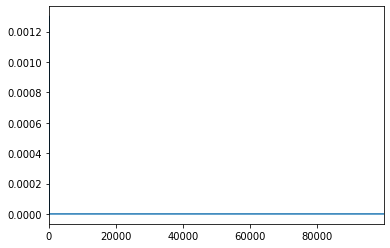

In [205]:
%matplotlib inline
import matplotlib
pandas.Series(pyAinterest).plot()

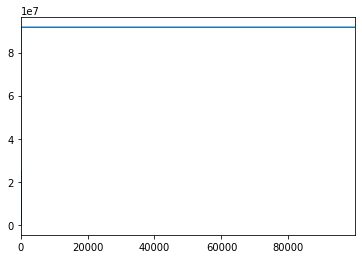

In [208]:
pandas.Series(qxA).plot()

In [209]:
qxA

[1790795,
 0,
 0,
 0,
 0,
 17046386,
 21126425,
 23166445,
 24186455,
 24696460,
 24951463,
 25078964,
 25142714,
 0,
 41827969,
 75110820,
 75114804,
 75116796,
 75117792,
 75118290,
 75118539,
 75118664,
 66800006,
 79278118,
 85517174,
 89676542,
 89676545,
 89676548,
 89676548,
 88636708,
 90716388,
 90716388,
 90196468,
 90976348,
 91366288,
 91626248,
 91561258,
 91691238,
 91691238,
 91691238,
 91658743,
 91723733,
 91707486,
 91739981,
 91731857,
 91744043,
 91752166,
 91752166,
 91752166,
 91752166,
 91752166,
 91752166,
 91752166,
 91750135,
 91754197,
 91754197,
 91754197,
 91754197,
 91754197,
 91753182,
 91754705,
 91755467,
 91755974,
 91755848,
 91756101,
 91756101,
 91756038,
 91756165,
 91756165,
 91756165,
 91756133,
 91756181,
 91756213,
 91756213,
 91756205,
 91756220,
 91756220,
 91756216,
 91756224,
 91756224,
 91756224,
 91756222,
 91756226,
 91756225,
 91756227,
 91756227,
 91756227,
 91756227,
 91756227,
 91756227,
 91756228,
 91756228,
 91756228,
 91756228,
 9

In [144]:
Decimal(10 - Decimal(5)) / Decimal(5 - 2)

Decimal('1.666666666666666666666666667')

In [195]:
decimal.getcontext().prec = 18
decimal.getcontext().prec

18

In [200]:
decimal.getcontext().rounding = decimal.ROUND_DOWN